### Background:

Company develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.



MonReader is a new mobile document digitalization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.



Data Description:

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

#### This notebook walks through building a simple deep learning model that can automatically detect the flipped and unflipped pages.

In [1]:
import os
import cv2
import numpy as np
import random
import matplotlib.image as mpimg
from  matplotlib import pyplot as plt

### Examine data

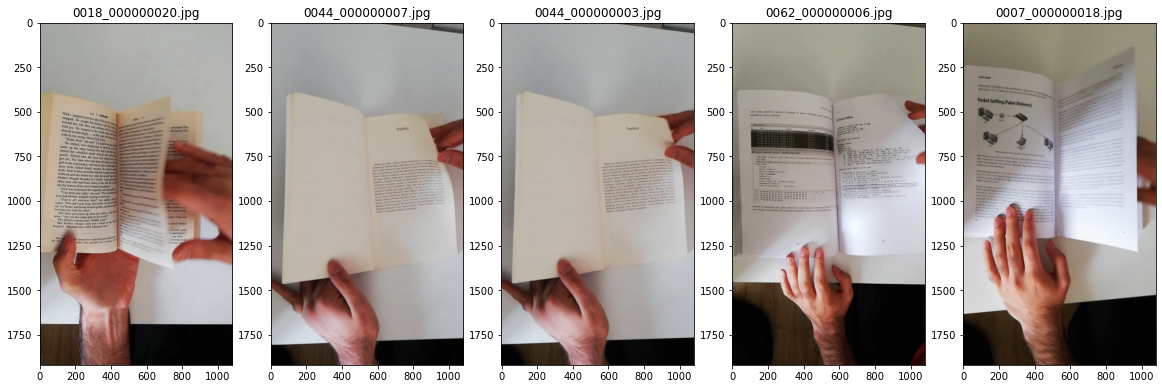

In [3]:
plt.figure(figsize=(20,20))

test_folder=r'C:\Users\rames\images\testing\flip'
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1) #plot the image where the figure is 1*5 and i+1 is the position of the image( one row and 5 col)
    ax.title.set_text(file)
    plt.imshow(img)

## Image Processing using OpenCV

OpenCV python is an open source library of python designed to solve computer vision problems.

In [4]:
def read_images(folder):
    images = []
    for filename in (os.listdir(folder)):
        img = cv2.imread(os.path.join(folder,filename))
        img = img[...,::-1]
        if img is not None:
            img = cv2.resize(img, dsize = (200,200), interpolation=cv2.INTER_AREA)
            y,h,x,w = 0,200,0,200 # y is the height of image,h is height of cropped, x is width and w is width of cropped img
            img = img[y:y+h, x:x+w] 
            img = img/255 # normalize image to 0-1 where 256 is the maximum value of a pixel,get floats ranging from 0-1
            images.append(img)
            
    return images


In [5]:
train_notflip = read_images("images/training/notflip")
train_flip = read_images("images/training/flip")

In [6]:
test_notflip = read_images("images/testing/notflip")
test_flip = read_images("images/testing/flip")

In [7]:
print('Training data contains %d of images that are flipped.' % len(train_flip))
print('Training data contains %d of images that are not flipped.' % len(train_notflip))


print('\nTesting data contains %d of images that are flipped.' % len(test_flip))
print('Testing data contains %d of images that are not flipped.' % len(test_notflip))

Training data contains 1162 of images that are flipped.
Training data contains 1230 of images that are not flipped.

Testing data contains 290 of images that are flipped.
Testing data contains 307 of images that are not flipped.


# Classification of data
We hav two classes, flip and notflip class. Label the fliped data with 1 and not flipped data with 0 and concatenate the image.

In [8]:
X_noflip = np.array(train_notflip)
X_flip = np.array(train_flip)

y_noflip = np.zeros(X_noflip.shape[0])
y_flip = np.ones(X_flip.shape[0])

X = np.concatenate((X_noflip,X_flip ))
y = np.concatenate((y_noflip, y_flip))

X.shape, y.shape

((2392, 200, 200, 3), (2392,))

In [9]:
X_test_noflip = np.array(test_notflip)
X_test_flip = np.array(test_flip)
y_test_noflip = np.zeros(X_test_noflip.shape[0])
y_test_flip = np.ones(X_test_flip.shape[0])


X_test = np.concatenate((X_test_noflip,X_test_flip ))
y_test = np.concatenate((y_test_noflip, y_test_flip))
X_test.shape, y_test.shape

((597, 200, 200, 3), (597,))

### Visualization of not flipped image with label

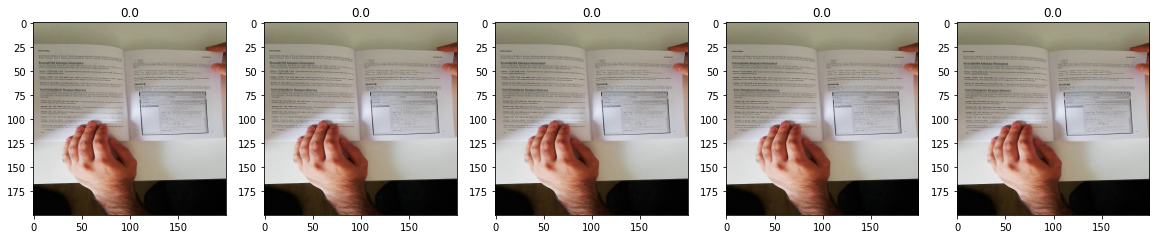

In [10]:
plt.figure(figsize=(20,20))
for i in range(5):
    ax=plt.subplot(1,5,i+1) #plot the image where the figure is 1*5 and i+1 is the position of the image( one row and 5 col)
    plt.imshow(X[i])
    plt.title(y[i])

### Visulalization of flipped image with label

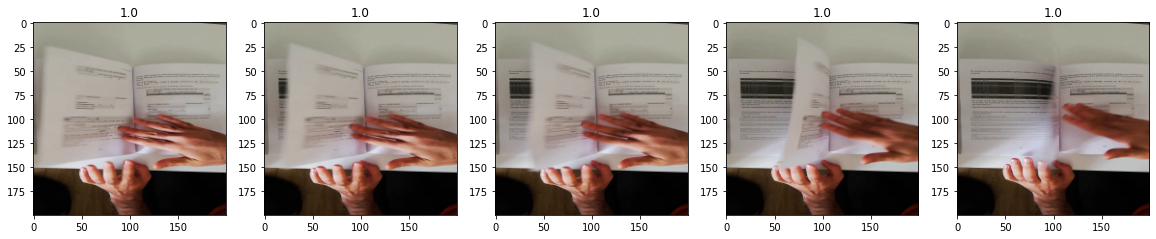

In [11]:
plt.figure(figsize=(20,20))
for i in range(-5,0):
    ax=plt.subplot(1,5,0-i) #plot the image where the figure is 1*5 and i+1 is the position of the image( one row and 5 col)
    plt.imshow(X[i])
    plt.title(y[i])

### Split into train, and evaluation sets
- Now that we have our image data matrix, X as well as our labels y , we can split our data into train, test and evaluation sets. To do so 20% of our data is allocated for evaluation set this is the data that our model never sees during training and will be used to score our trained model.

In [12]:
# Split out evaluation sets
from sklearn.model_selection import train_test_split
X_train,x_val,y_train,y_val = train_test_split(X,y,test_size = 0.2,random_state=52)

In [13]:
# Examine number of samples in train, test and validation sets
print('X_train shape:',X_train.shape)
print(X_train.shape[0],'train samples')
print(X_test.shape[0],'test samples')
print(x_val.shape[0],'validation samples')

X_train shape: (1913, 200, 200, 3)
1913 train samples
597 test samples
479 validation samples


## Model Building

Convolutional neural network(CNN) are a specific kind of artificial neural network that is very effective for image classfication because they are able to take into account the spatial coherence of the image i.e, that pizels close to each other are often related.

Building a CNN begins with specifying the model type. In our case we used Sequential model which is a linear stack of layers. And add two convolutional layers. Convolutional layers pass a kernel (a sliding window) over the image and perform element-wise matrix multiplication between kernel values and the pixel values in the image.


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import keras
from keras.models import Model

In [15]:
cnn_model = Sequential()

#first convolutional layer with 32 filters
cnn_model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (200,200,3)))
cnn_model.add(AveragePooling2D((2,2)))

#add a second convolutional layers with 64 filters
cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))

So far our model has two convolutional layers. However, those are not the only layers that we need to perform our task. A complete neural network architechture will have a number of other layers that are designed to play a specific role in the overall functioning of the network. We'll add the following layers:
- AveragePooling : This passes a (2,2) sliding window over the image and downscales the image by outputting the average value within the window.
- Flatten : This flattens the output from the convolutional part of the CNN into a one dimensional feature vector which can be passed in the fully connected layers.
- Dense : Final layer which calculates the probability the image is either flipped or not flipped.

In [ ]:
#Reduce dimensionality through average pooling
cnn_model.add(AveragePooling2D((2,2)))

#necessary flatten step  preceding dense layer
cnn_model.add(Flatten())

# final layer which calculates the probability of the image is either flipped or not fipped
cnn_model.add(Dense(units = 120, activation = 'relu'))

cnn_model.add(Dense(units = 84, activation = 'relu'))

cnn_model.add(Dense(units = 43, activation = 'softmax'))

In [16]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 average_pooling2d (AverageP  (None, 99, 99, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 48, 48, 64)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 147456)            0         
                                                                 
 dense (Dense)               (None, 120)               1

## Compile and train model

Now that we've specified the model architecture, we will compile the model for training. First we speficied the loss function(what we are trying to minimize), the optimizer(how we want to go about minimizing the loss),and the metric. Then we'll call .fit to begin the training process.

In [18]:
cnn_model.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer = Adam(learning_rate = 0.001), 
                  metrics = ['accuracy'])

In [19]:
history = cnn_model.fit(X_train, 
              y_train, 
              batch_size = 64, 
              epochs = 10, 
              verbose = 1, 
              validation_data = (x_val, y_val))

Epoch 1/10
30/30 [==============================] - 23s 756ms/step - loss: 0.9207 - accuracy: 0.5468 - val_loss: 0.6470 - val_accuracy: 0.5678
Epoch 2/10
30/30 [==============================] - 28s 943ms/step - loss: 0.4781 - accuracy: 0.7705 - val_loss: 0.3204 - val_accuracy: 0.9019
Epoch 3/10
30/30 [==============================] - 26s 870ms/step - loss: 0.2161 - accuracy: 0.9300 - val_loss: 0.2096 - val_accuracy: 0.9040
Epoch 4/10
30/30 [==============================] - 28s 940ms/step - loss: 0.1502 - accuracy: 0.9456 - val_loss: 0.1189 - val_accuracy: 0.9562
Epoch 5/10
30/30 [==============================] - 28s 947ms/step - loss: 0.0704 - accuracy: 0.9749 - val_loss: 0.0661 - val_accuracy: 0.9770
Epoch 6/10
30/30 [==============================] - 29s 954ms/step - loss: 0.0499 - accuracy: 0.9859 - val_loss: 0.0600 - val_accuracy: 0.9770
Epoch 7/10
30/30 [==============================] - 29s 969ms/step - loss: 0.0254 - accuracy: 0.9927 - val_loss: 0.0422 - val_accuracy: 0.9812

In [20]:
##Model Evaluation

In [21]:
score = cnn_model.evaluate(X_test, y_test)
print('Test accuracy: {}'.format(score[1]))

19/19 [==============================] - 3s 160ms/step - loss: 0.0632 - accuracy: 0.9849
Test accuracy: 0.9849246144294739


In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

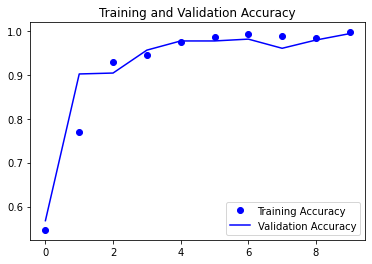

In [24]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

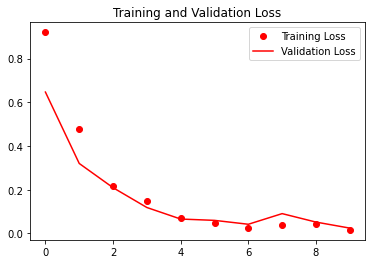

In [25]:
plt.plot(epochs, loss, 'ro', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [26]:
predicted_classes = np.argmax(cnn_model.predict(X_test), axis = -1)
y_true = y_test

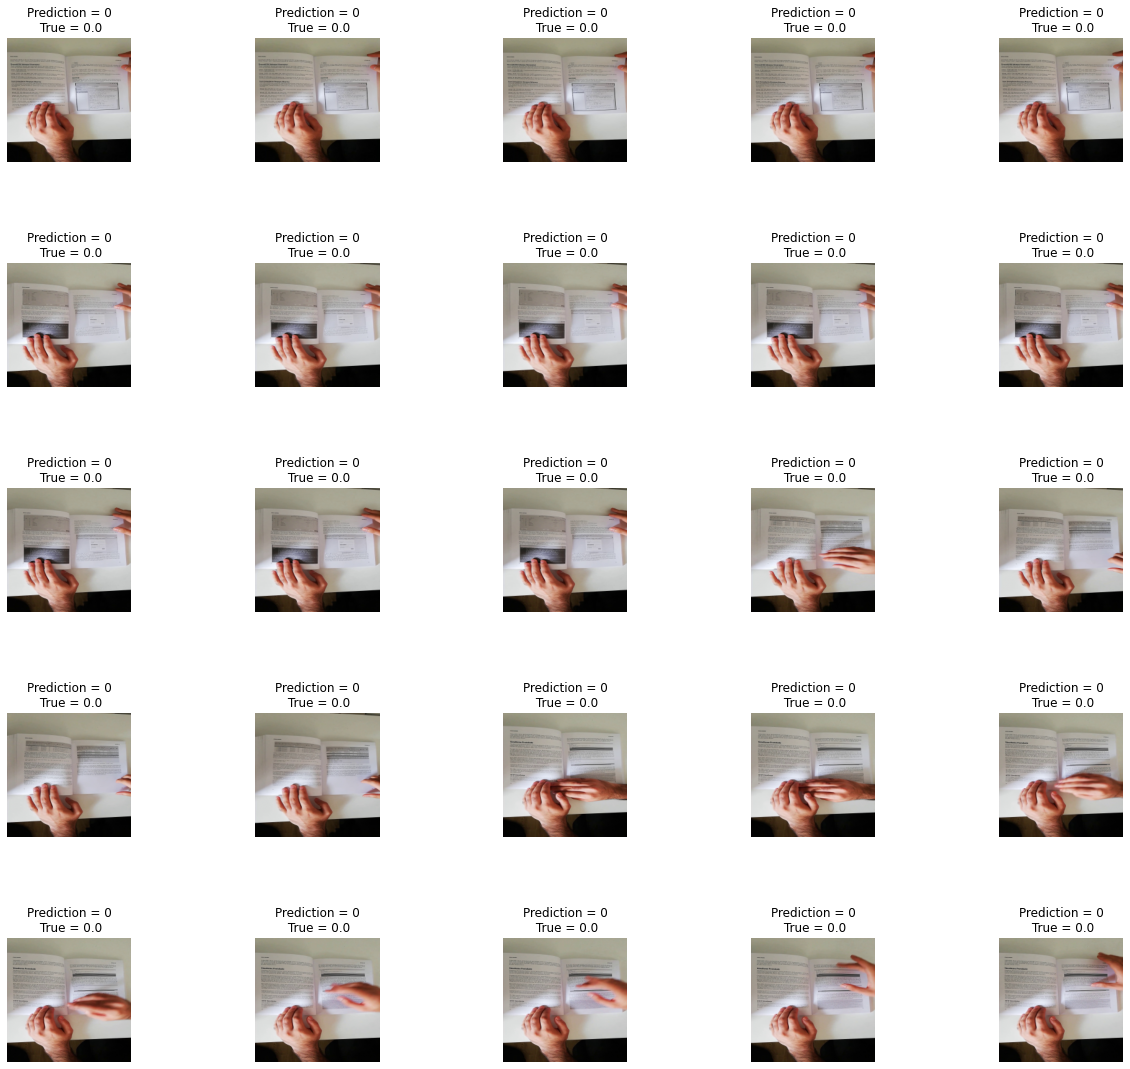

In [27]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (20,20))
axes = axes.ravel()

for i in np.arange(0, L * W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(predicted_classes[i], y_true[i]))
    axes[i].axis('off')
    
plt.subplots_adjust(wspace = 1)

## Conclusion

Our model test core is 98.49% with a loss equal to 0.06